# Load Data

In [1]:
# Import Needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.target import FeatureCorrelation
from yellowbrick.classifier import ClassBalance, ClassificationReport, ConfusionMatrix, DiscriminationThreshold
from yellowbrick.features import JointPlotVisualizer, PCADecomposition, RadViz, Rank1D, Rank2D
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier, XGBRFClassifier
import warnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set(rc={'figure.figsize': (15, 6)})

In [3]:
# Load data from UCI dataset repo
bank_note_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
data = np.loadtxt(bank_note_url, delimiter=',')
data = pd.DataFrame(data)

# Add column names
clean_columns = ['variance_of_wavelet', 'skewness_of_wavelet',
                 'curtosis_of_wavelet', 'entropy_of_wavelet',
                 'class']

data.columns = clean_columns

In [4]:
data.head()

,variance_of_wavelet,skewness_of_wavelet,curtosis_of_wavelet,entropy_of_wavelet,class
0,3.62160,8.6661,-2.8073,-0.44699,0.0
1,4.54590,8.1674,-2.4586,-1.46210,0.0
2,3.86600,-2.6383,1.9242,0.10645,0.0
3,3.45660,9.5228,-4.0112,-3.59440,0.0
4,0.32924,-4.4552,4.5718,-0.98880,0.0


## Training & Validation Split

In [5]:
# Separate the target and features as separate dataframes for sklearn APIs
X = data.drop('class', axis=1)
y = data[['class']].astype('int')


# Specify the design matrix and the target vector for yellowbrick as arrays
design_matrix = X.values
target_vector = y.values.flatten()

In [6]:
X.head()

,variance_of_wavelet,skewness_of_wavelet,curtosis_of_wavelet,entropy_of_wavelet
0,3.62160,8.6661,-2.8073,-0.44699
1,4.54590,8.1674,-2.4586,-1.46210
2,3.86600,-2.6383,1.9242,0.10645
3,3.45660,9.5228,-4.0112,-3.59440
4,0.32924,-4.4552,4.5718,-0.98880


In [7]:
y.head()

,class
0,0
1,0
2,0
3,0
4,0


In [8]:
# Stratified sampling based on the distribution of the target vector, y
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=30)

In [9]:
# Stage 1. Feature Analysers
feature_names = X.columns.tolist()
target_name = y.columns.tolist()

# Stage 1 - EDA 

## Target Balance

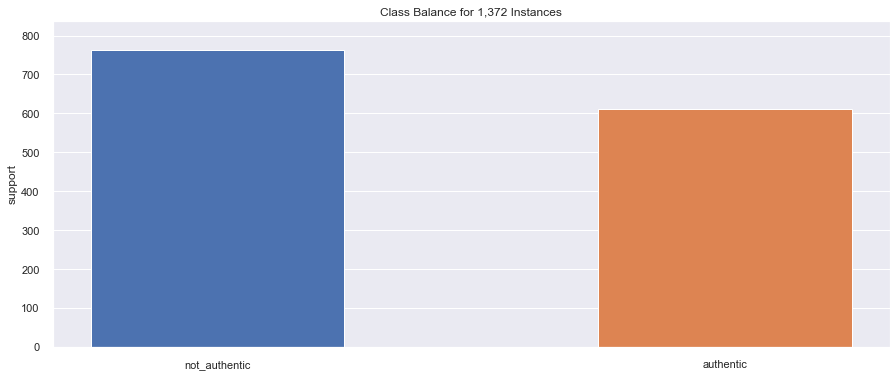

In [10]:
# Target balance
target_balance = ClassBalance(labels=['not_authentic', 'authentic'])
target_balance.fit(target_vector)
target_balance.show();

## Feature Correlation

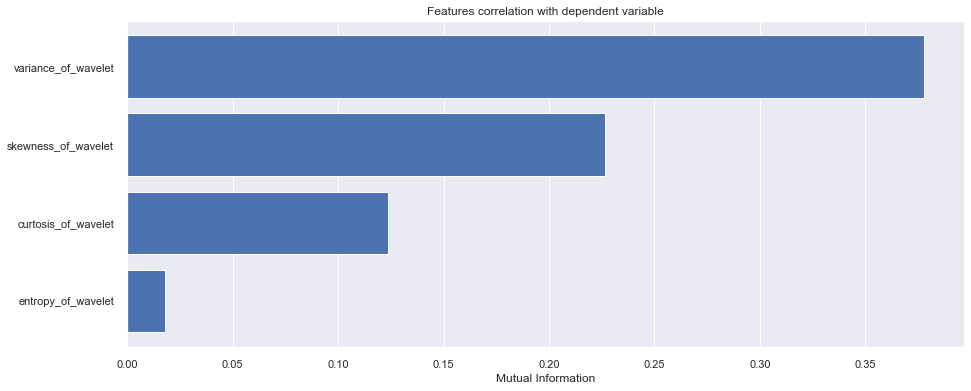

In [11]:
# Feature correlation (** requires dataframe and 1D target vector)
feature_correlation = FeatureCorrelation(method='mutual_info-classification',
                                         feature_names=feature_names, sort=True)
feature_correlation.fit(X, y.values.flatten())
feature_correlation.show();

## RadViz

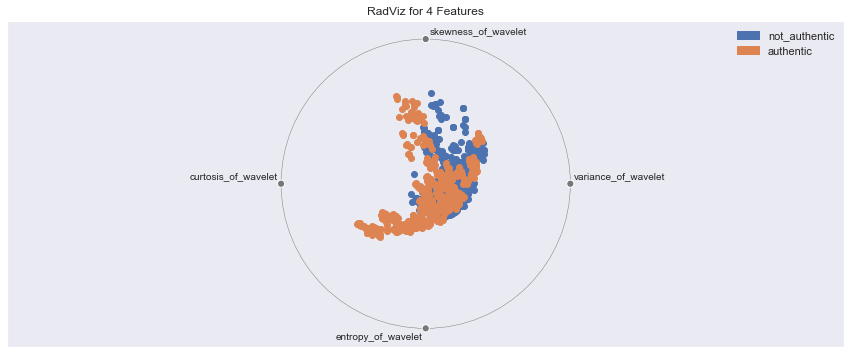

In [12]:
# Radviz
rad_viz = RadViz(classes=['not_authentic', 'authentic'],
                 features=feature_names)

rad_viz.fit(design_matrix, target_vector)
rad_viz.show()

## 1D Feature Rankings

/home/mysterio/miniconda3/envs/pydata/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


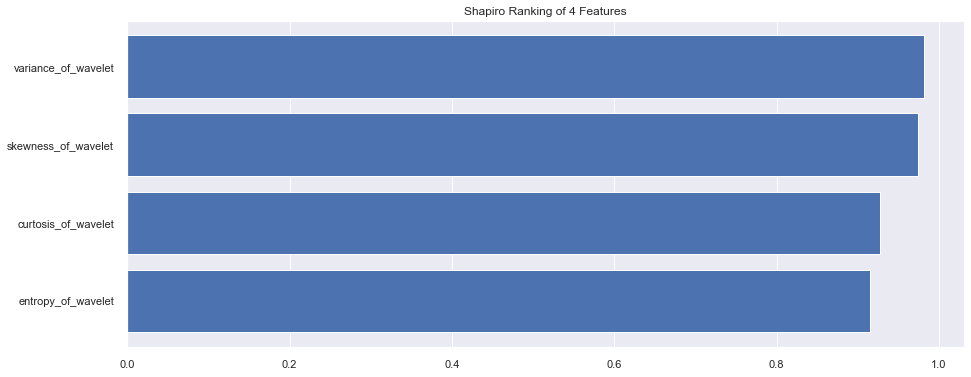

array([[  3.6216 ,   8.6661 ,  -2.8073 ,  -0.44699],
       [  4.5459 ,   8.1674 ,  -2.4586 ,  -1.4621 ],
       [  3.866  ,  -2.6383 ,   1.9242 ,   0.10645],
       ...,
       [ -3.7503 , -13.4586 ,  17.5932 ,  -2.7771 ],
       [ -3.5637 ,  -8.3827 ,  12.393  ,  -1.2823 ],
       [ -2.5419 ,  -0.65804,   2.6842 ,   1.1952 ]])

In [13]:
# 1D Rank
rank_1d = Rank1D(algorithm='shapiro', features=feature_names)
rank_1d.fit_transform_show(design_matrix, target_vector)

## 2D Rank

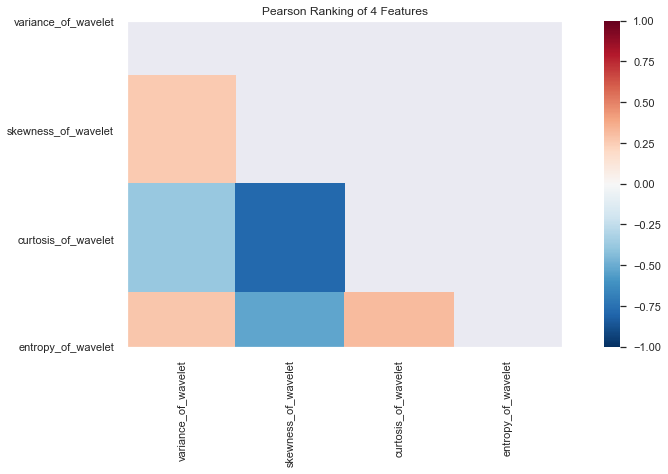

In [14]:
# 2D Rank
rank_2d = Rank2D(algorithm='pearson', features=feature_names)
rank_2d.fit_transform_show(design_matrix, target_vector);

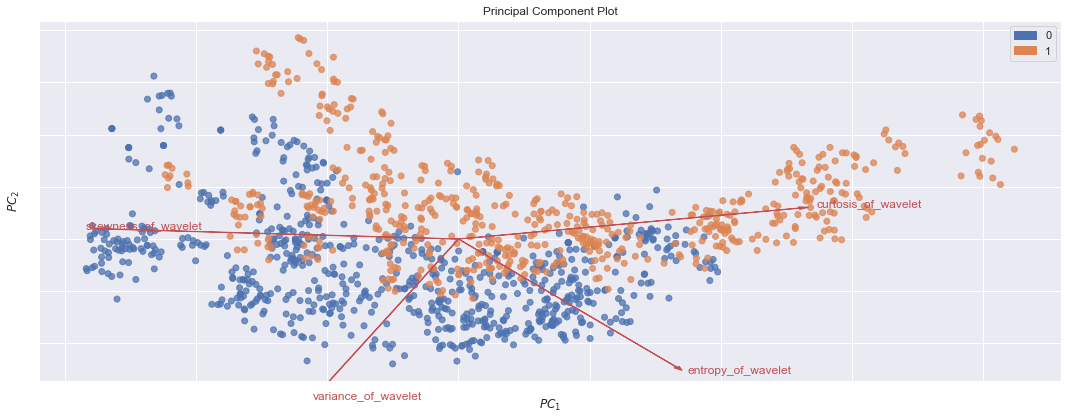

array([[-1.47280494, -1.16391668],
       [-1.63944068, -1.09381204],
       [ 0.51391884, -1.32487953],
       ...,
       [ 4.04932734,  2.03602288],
       [ 3.01961738,  1.39214023],
       [ 1.17058249,  0.09103094]])

In [15]:
# PCA Projection
colors = np.array(['red' if yi else 'blue' for yi in target_vector])

pca = PCADecomposition(scale=True, proj_features=True, features=feature_names)
pca.fit_transform_show(design_matrix, target_vector, colors=colors)

In [16]:
colors

array(['blue', 'blue', 'blue', ..., 'red', 'red', 'red'], dtype='<U4')

# Model Selection

In [17]:
# Model Selection
models = [
    DummyClassifier(strategy='most_frequent'), LogisticRegression(),
    SGDClassifier(), LogisticRegressionCV(), HistGradientBoostingClassifier(),
    RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(),
    BaggingClassifier(), AdaBoostClassifier(), XGBClassifier(),
    XGBRFClassifier(), MLPClassifier(max_iter=1000), LinearSVC(), NuSVC(), SVC(),
    GaussianNB(), DecisionTreeClassifier(), QuadraticDiscriminantAnalysis(),
    KNeighborsClassifier(n_neighbors=2), GaussianProcessClassifier()
]

In [18]:
def training_cv_score_model(X, y, model):
    """
    This function takes the design matrix and target vector of the training set,
    along with a classification estimator and computes a 10 fold cross validated
    mean and standard deviation based on balanced accuracy.
    This score is printed to the end user.
    """
    numeric_transformer = Pipeline(steps=[
        ('scale_x_num', StandardScaler())
    ])

    pre_processor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, feature_names)
    ])

    clf = Pipeline(steps=[
        ('preprocessor', pre_processor),
        ('classifier', model)
    ])

    scores = cross_val_score(clf,
                             X,
                             y.values.flatten(),
                             scoring='balanced_accuracy',
                             cv=10)

    mean_score = scores.mean()
    avg_score = scores.std()

    model_name = clf.named_steps['classifier'].__class__.__name__

    print(f'{model_name}, Average Score : {mean_score} & Standard Deviation: {avg_score}')
    print('-'*90)

In [19]:
def out_of_sample_score(train_features, train_target, test_features, test_target, model):
    """
    This function takes the design matrix and target vector of the validation set,
    along with a classification estimator and
    scores the predicted classes and true values via a balanced accuracy score.
    This score is printed to the end user.
    """
    numeric_transformer = Pipeline(steps=[
        ('scale_x_num', StandardScaler())
    ])

    pre_processor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, feature_names)
    ])

    clf = Pipeline(steps=[
        ('preprocessor', pre_processor),
        ('classifier', model)
    ])

    model_name = clf.named_steps['classifier'].__class__.__name__

    clf.fit(train_features, train_target.values.ravel())

    preds = clf.predict(test_features)
    score = balanced_accuracy_score(y_true=test_target, y_pred=preds)

    print(f'{model_name} with balanced accuracy on test set {score}')
    print('-'*90)

In [20]:
def visualise_out_of_sample(train_features, train_target, test_features, test_target, model):
    """
    This function takes the design matrix and target vector of the validation set,
    along with a classification estimator and
    scores the predicted classes and true values via a classification report and
    a confusion matrix.
    """
    # Classification pipeline
    numeric_transformer = Pipeline(steps=[
        ('scale_x_num', StandardScaler())
    ])

    pre_processor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, feature_names)
    ])

    clf = Pipeline(steps=[
        ('preprocessor', pre_processor),
        ('classifier', model)
    ])

    # Classification report
    clf_report = ClassificationReport(clf, classes=['not_authentic', 'authentic'],
                                      cmap="YlGn", size=(600, 360))

    clf_report.fit(train_features, train_target.values.flatten())
    clf_report.score(test_features, test_target.values.flatten())
    clf_report.show()

    # Confusion matrix
    cm = ConfusionMatrix(clf, classes=['not_authentic', 'authentic'])


    cm.fit(train_features, y_train.values.flatten())
    cm.score(test_features, test_target.values.flatten())
    cm.show()

In [21]:
for model in models:
    try:
        training_cv_score_model(X_train, y_train, model)
    except Exception as e:
        raise e


DummyClassifier, Average Score : 0.5 & Standard Deviation: 0.0
------------------------------------------------------------------------------------------
LogisticRegression, Average Score : 0.9840110962417754 & Standard Deviation: 0.013227519398728642
------------------------------------------------------------------------------------------
SGDClassifier, Average Score : 0.9842376909780306 & Standard Deviation: 0.015981873206751485
------------------------------------------------------------------------------------------
LogisticRegressionCV, Average Score : 0.9891389957622392 & Standard Deviation: 0.008700802791904006
------------------------------------------------------------------------------------------
HistGradientBoostingClassifier, Average Score : 0.9963198394111743 & Standard Deviation: 0.006119340255428127
------------------------------------------------------------------------------------------
RandomForestClassifier, Average Score : 0.9956872421099587 & Standard Deviation: 

In [22]:
for model in models:
    try:
        out_of_sample_score(X_train, y_train, X_test, y_test, model)
    except Exception as e:
        raise e

DummyClassifier with balanced accuracy on test set 0.5
------------------------------------------------------------------------------------------
LogisticRegression with balanced accuracy on test set 0.9803921568627452
------------------------------------------------------------------------------------------
SGDClassifier with balanced accuracy on test set 0.9852673309761063
------------------------------------------------------------------------------------------
LogisticRegressionCV with balanced accuracy on test set 0.9901960784313726
------------------------------------------------------------------------------------------
HistGradientBoostingClassifier with balanced accuracy on test set 0.9967320261437909
------------------------------------------------------------------------------------------
RandomForestClassifier with balanced accuracy on test set 0.9811689703203685
------------------------------------------------------------------------------------------
ExtraTreesClassifier 

/home/mysterio/miniconda3/envs/pydata/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


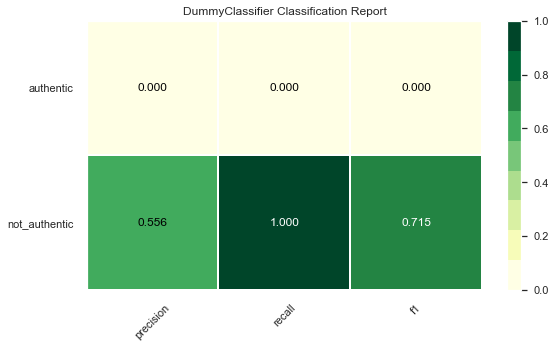

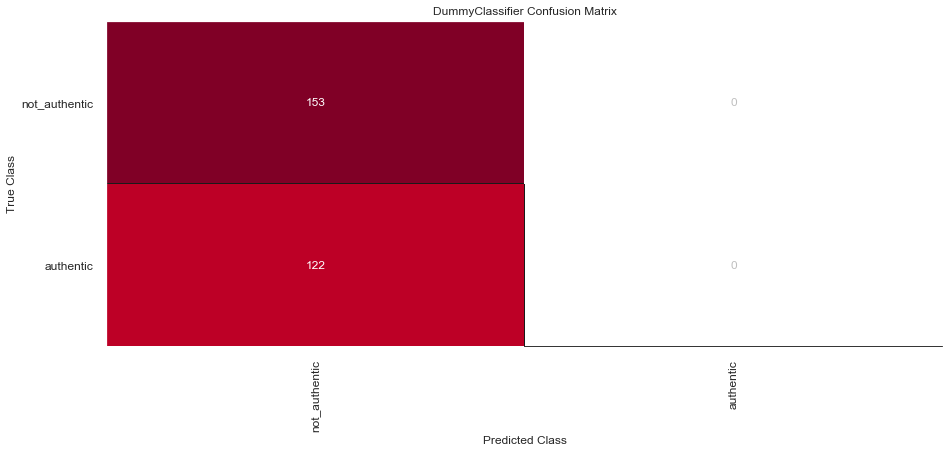

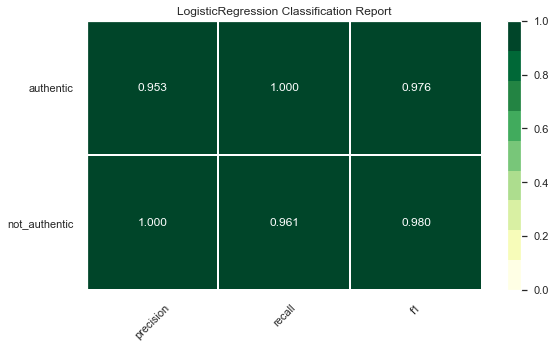

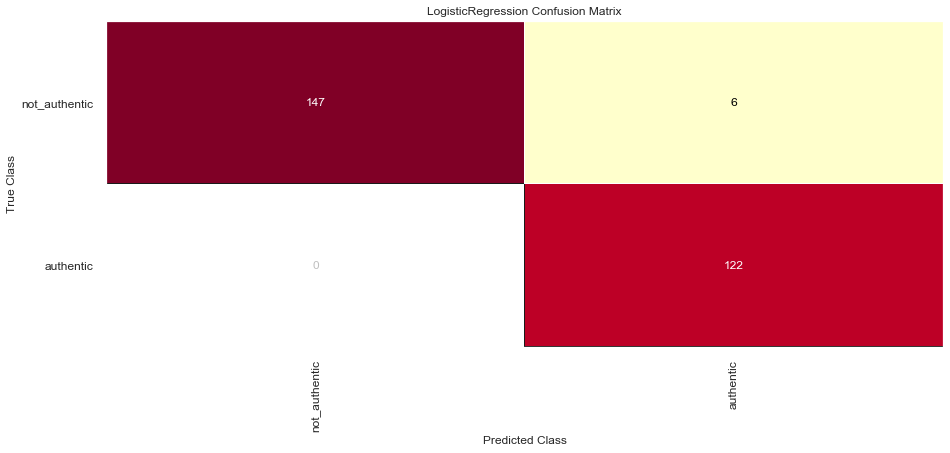

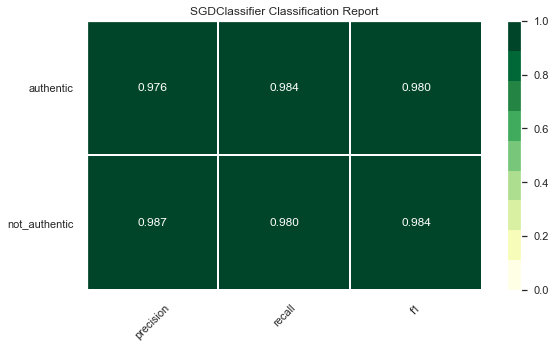

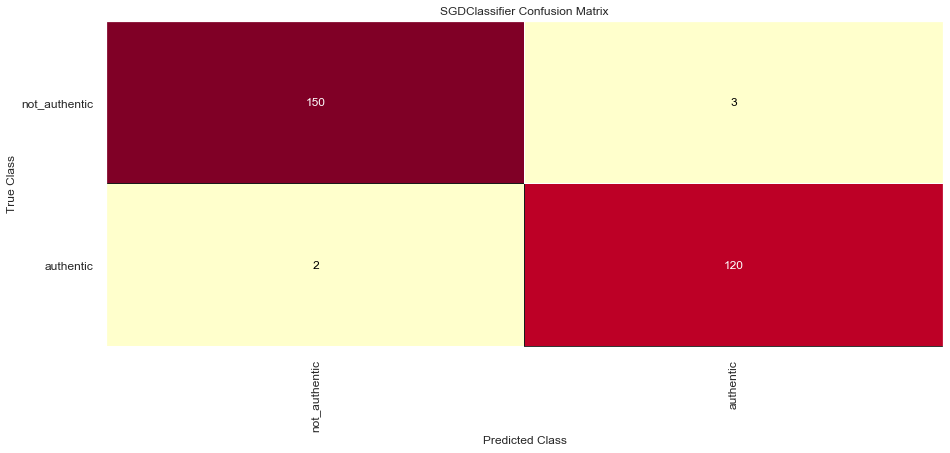

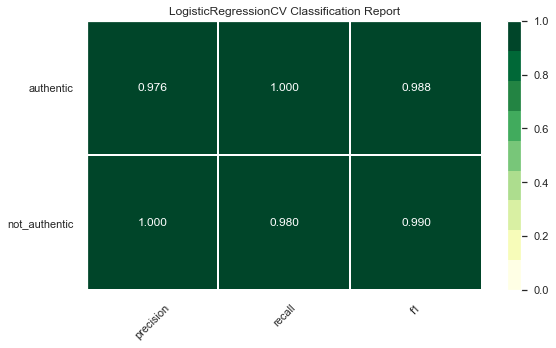

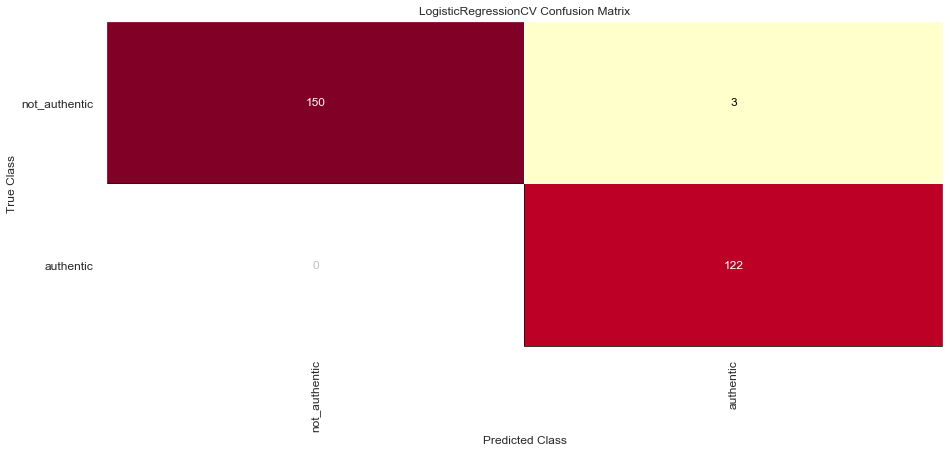

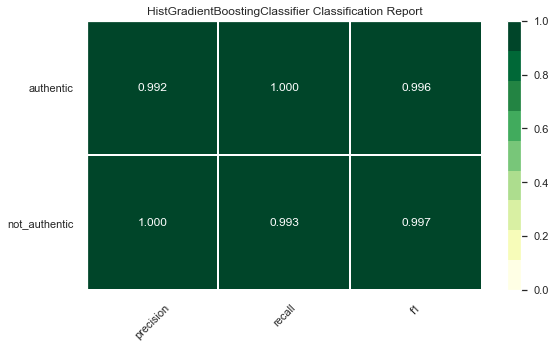

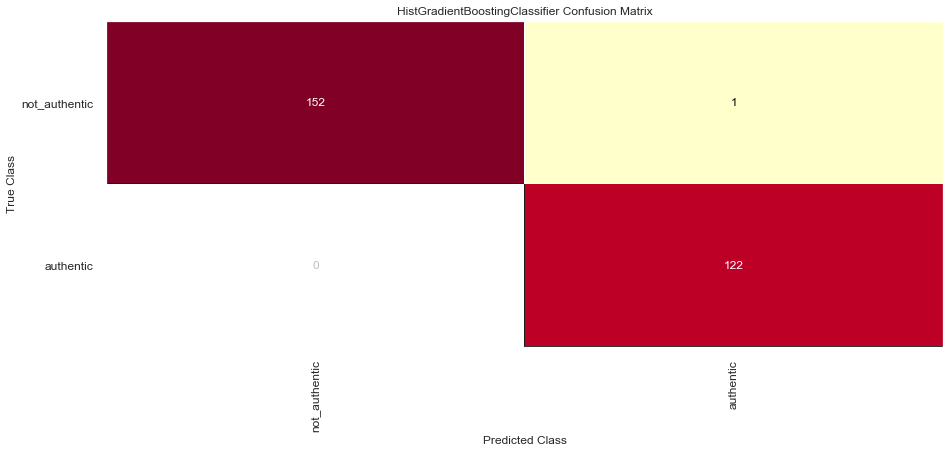

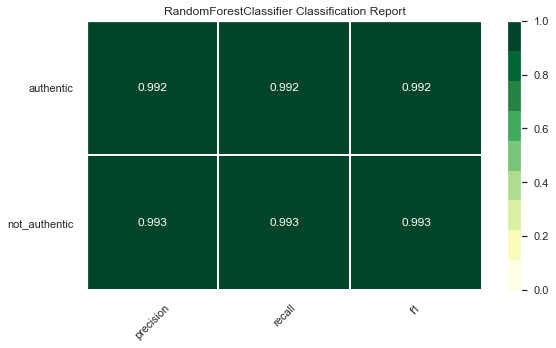

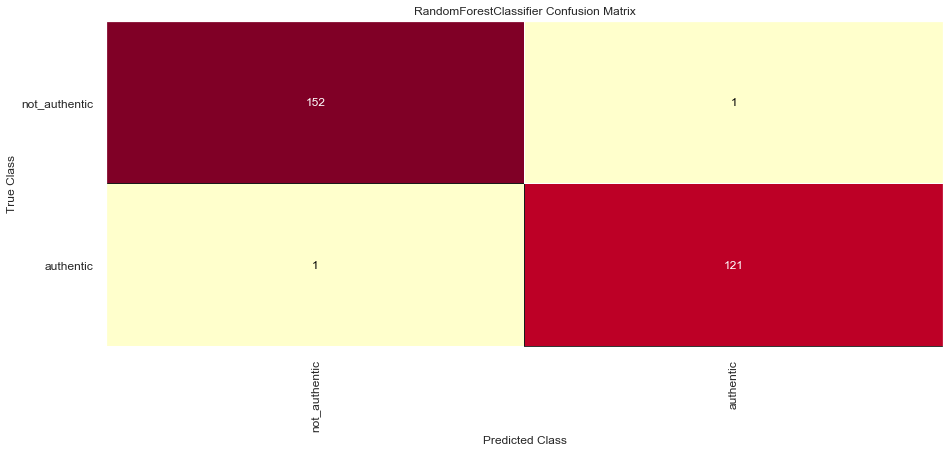

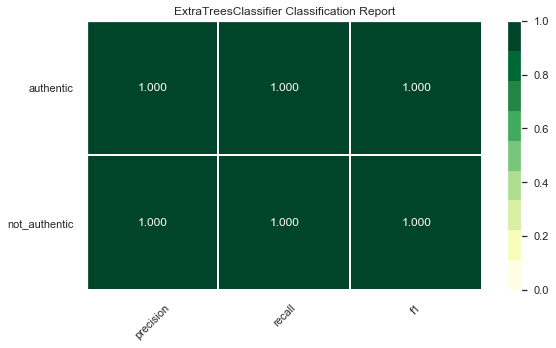

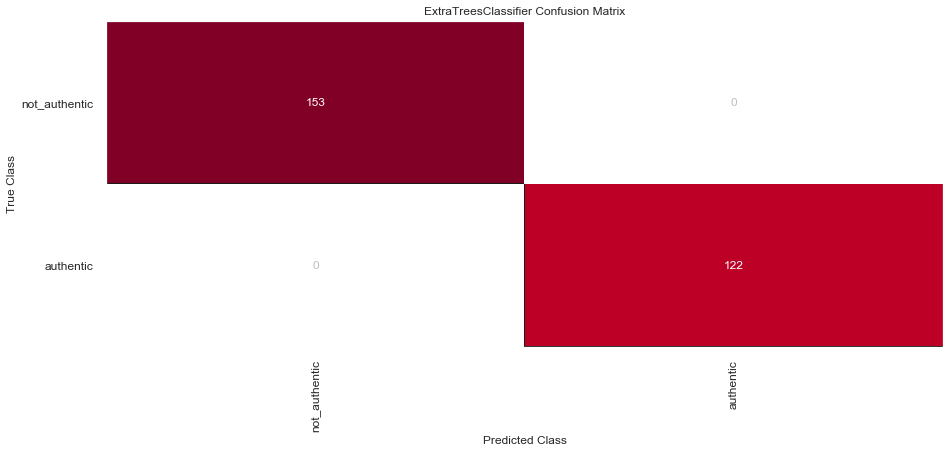

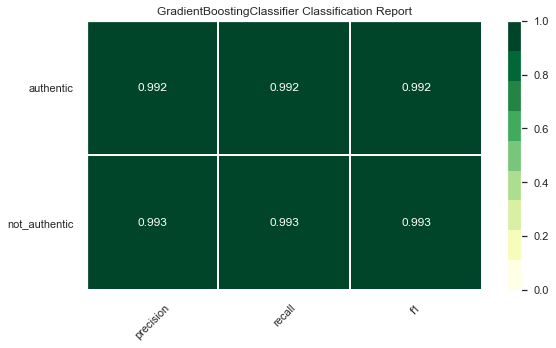

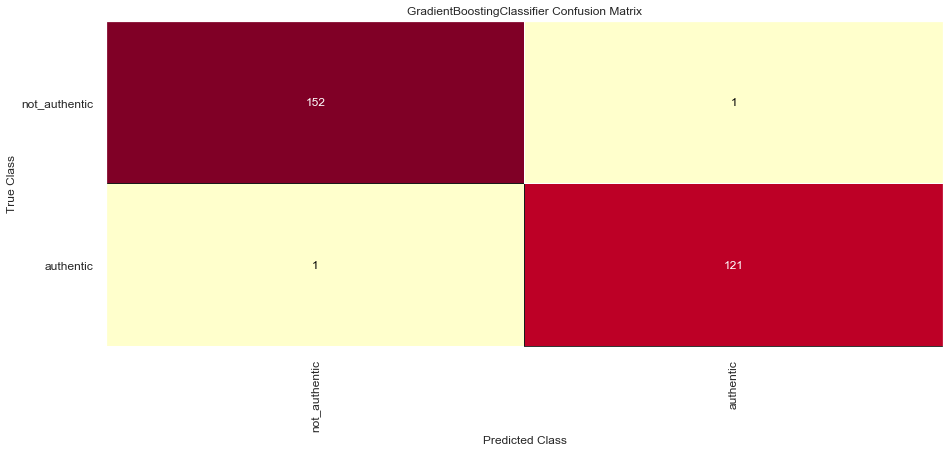

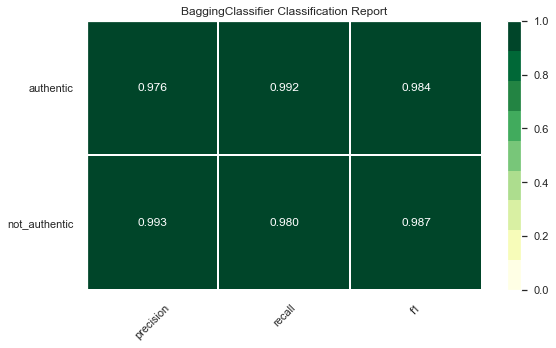

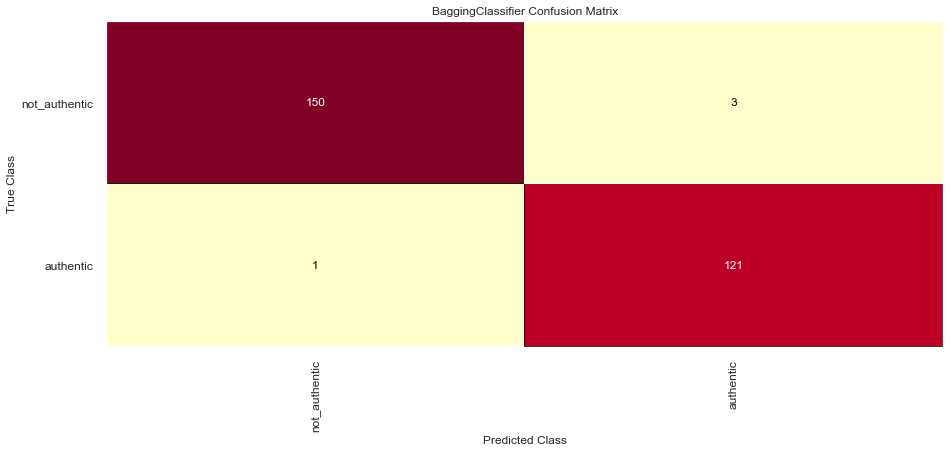

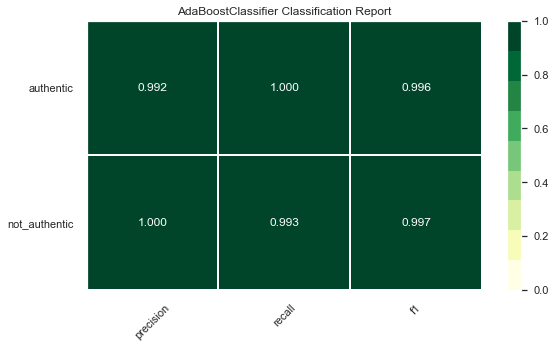

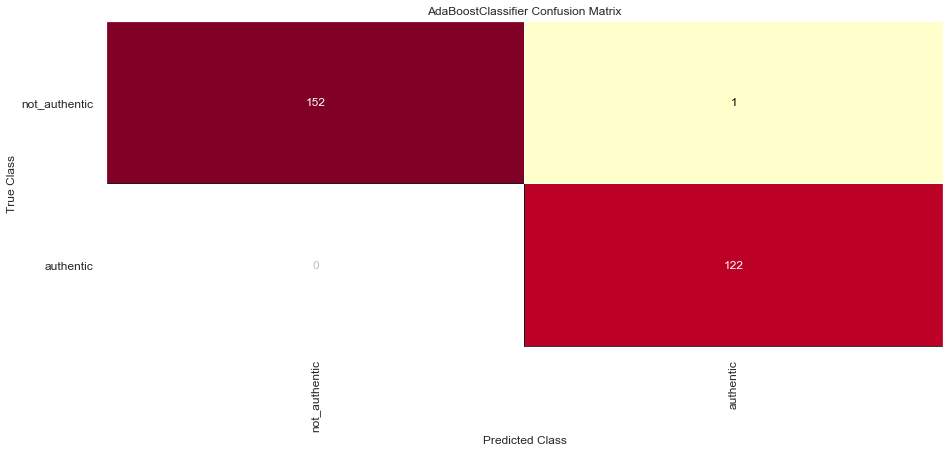

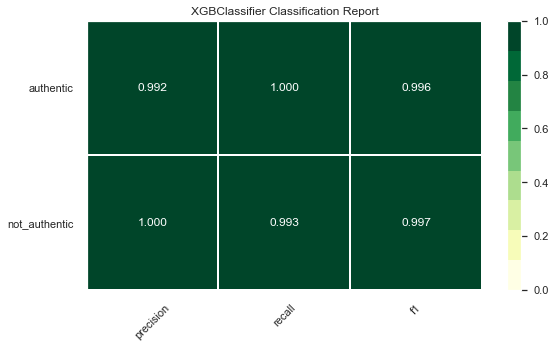

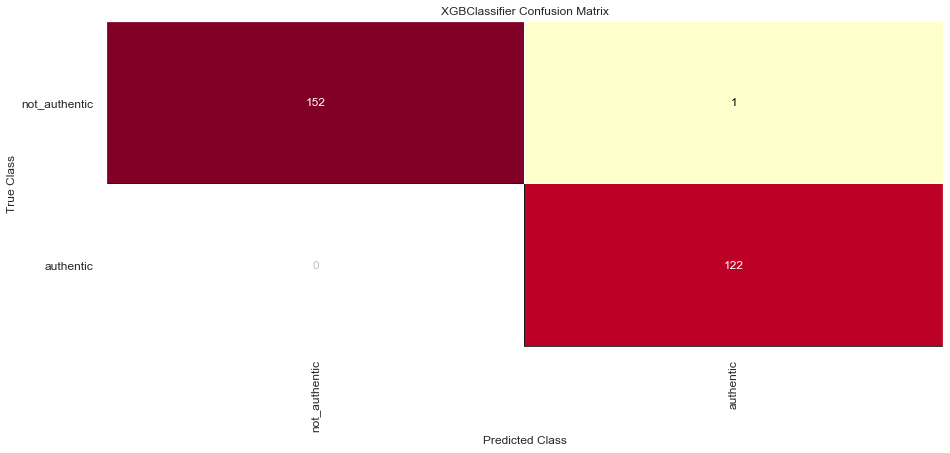

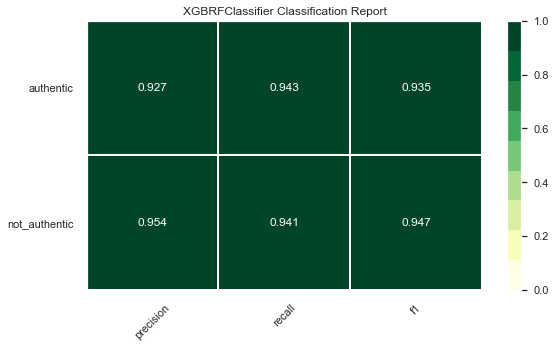

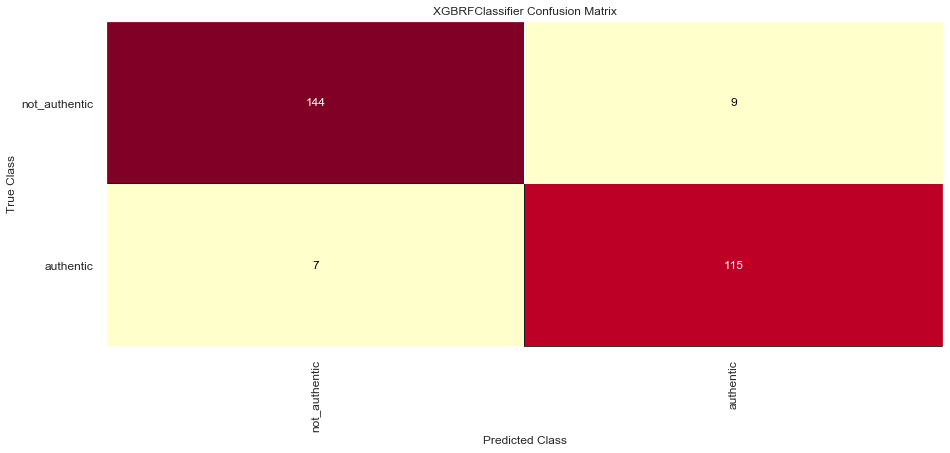

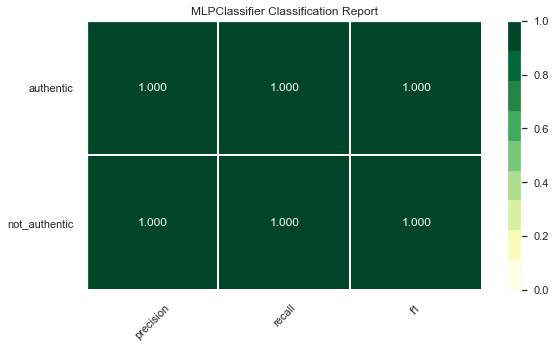

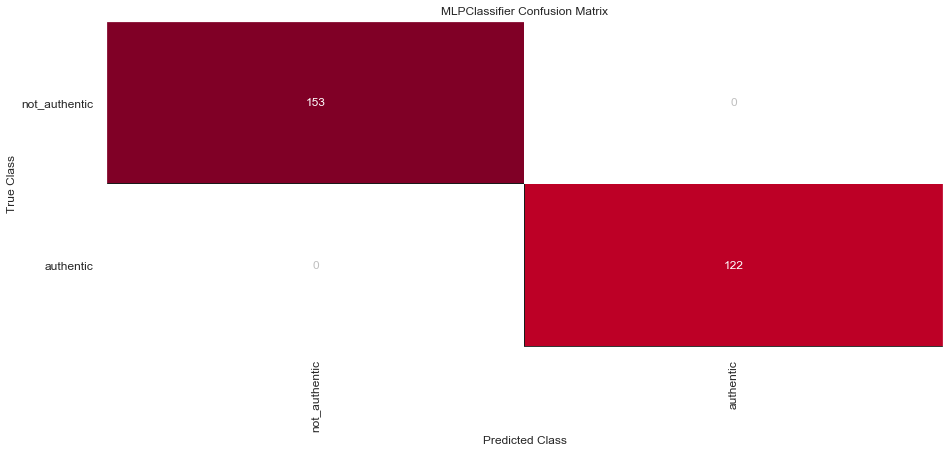

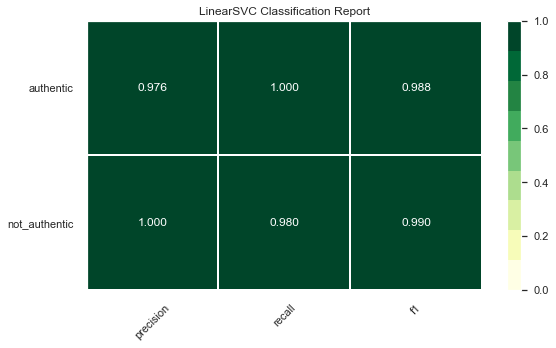

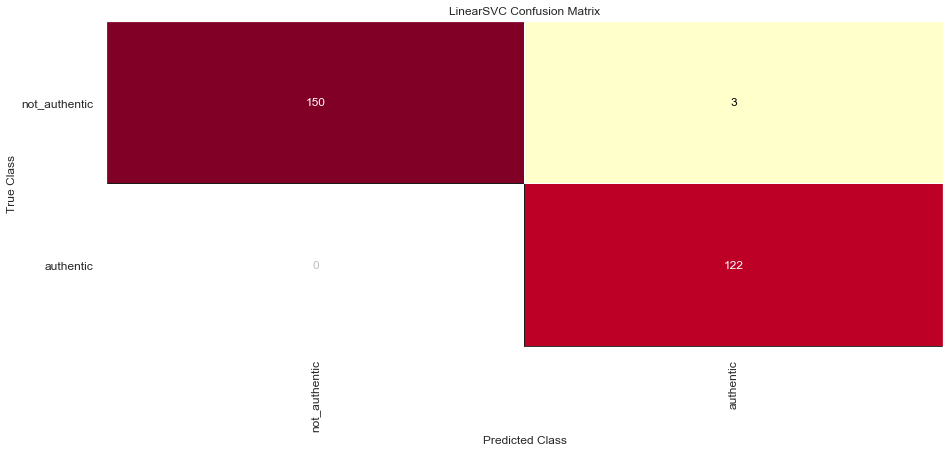

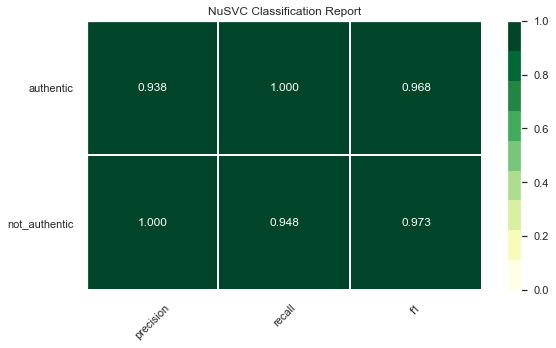

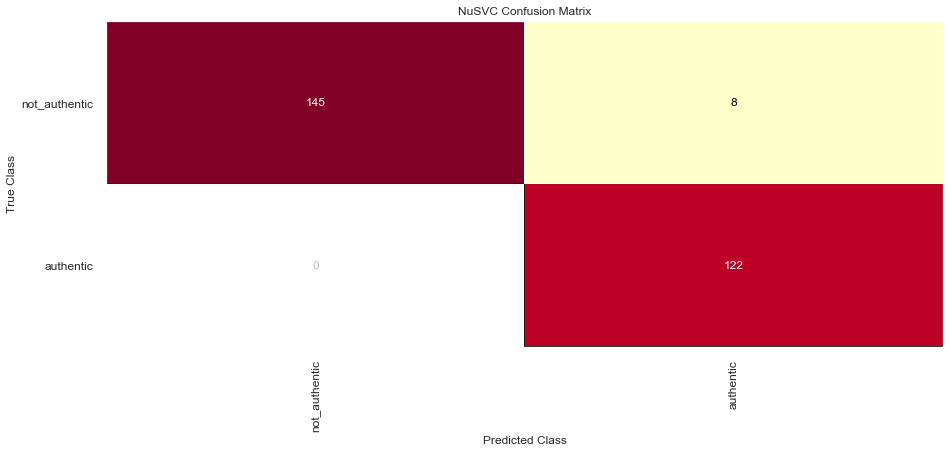

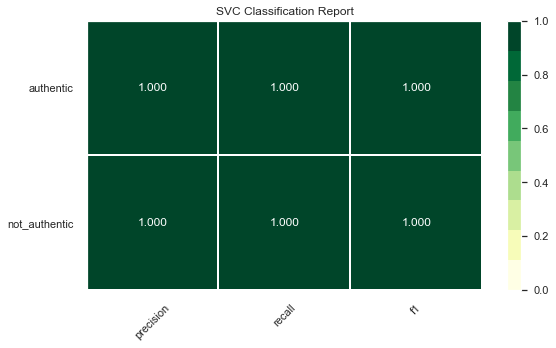

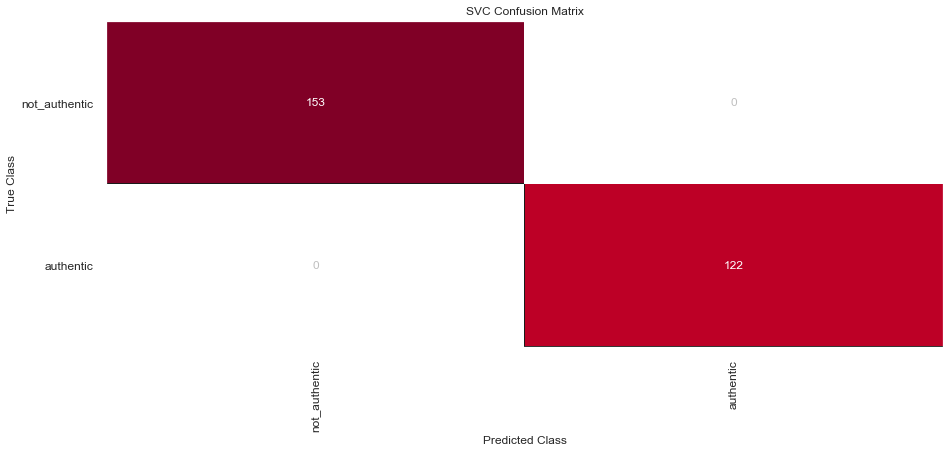

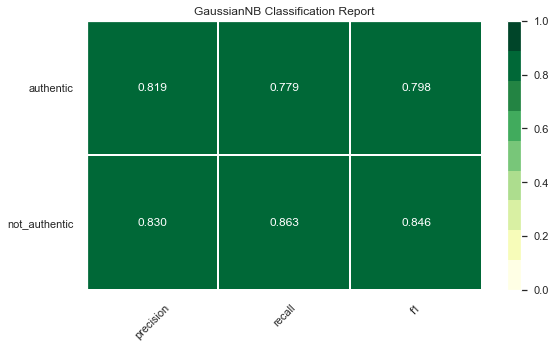

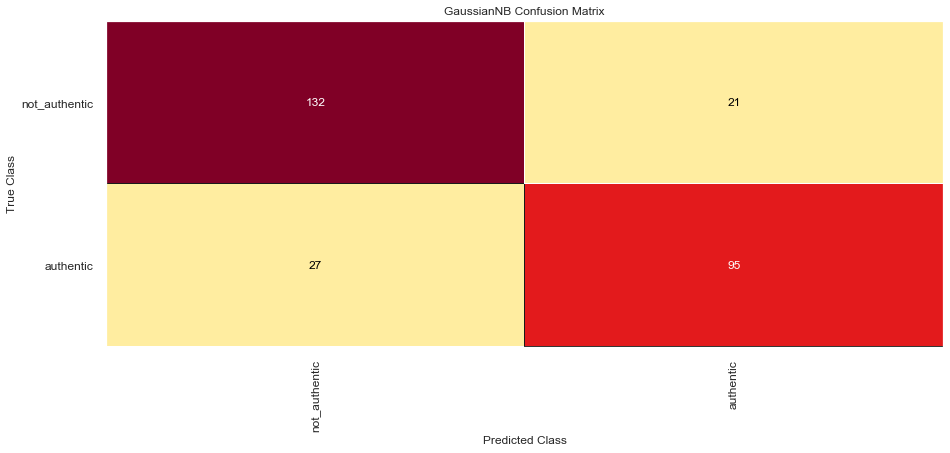

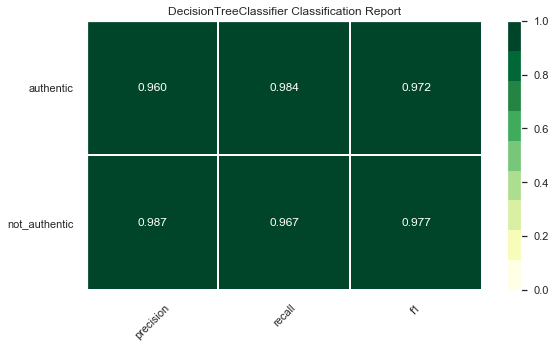

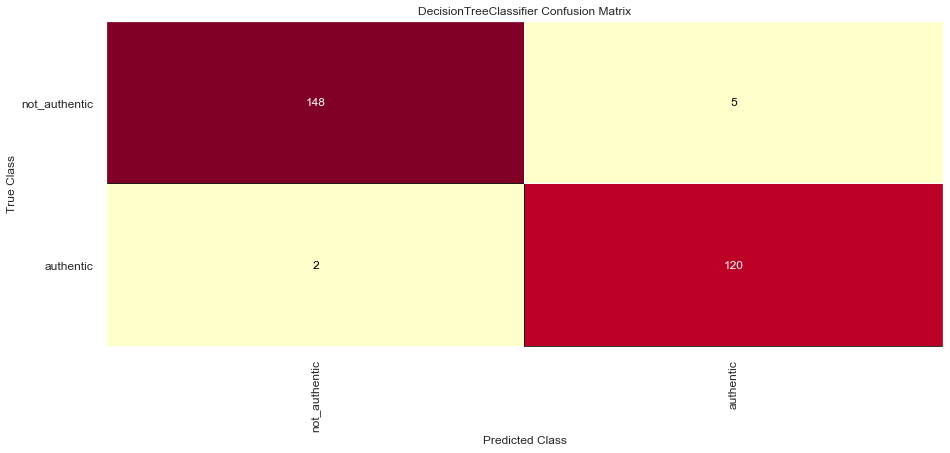

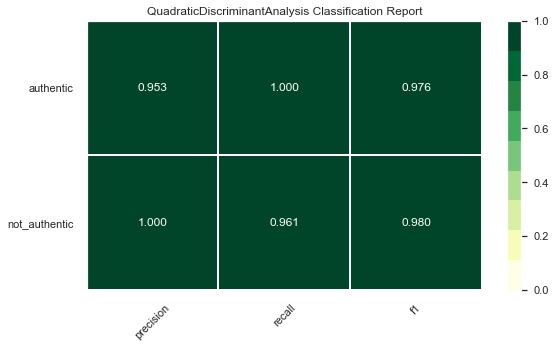

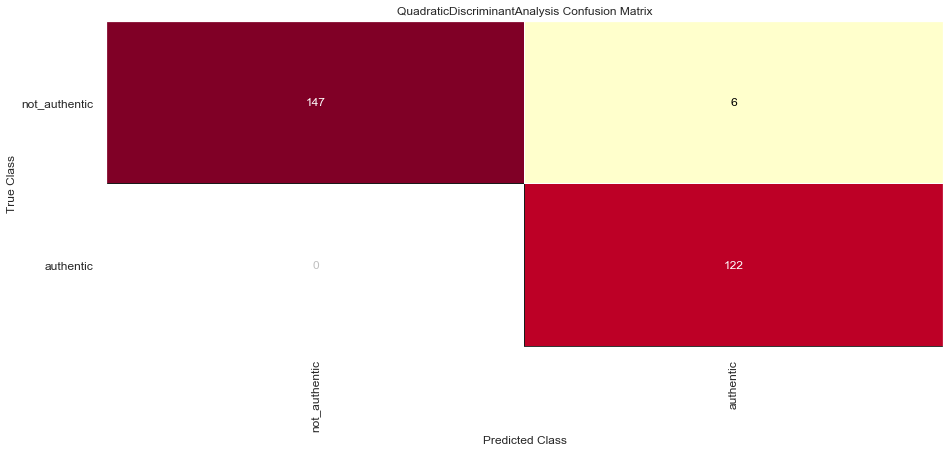

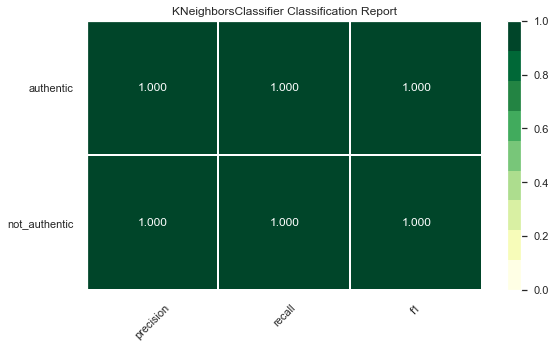

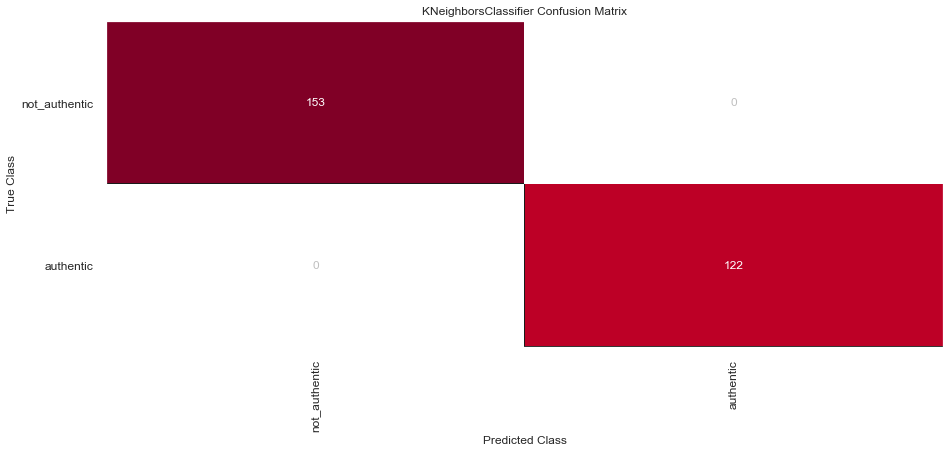

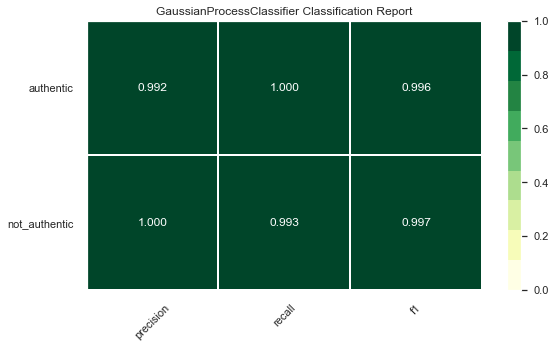

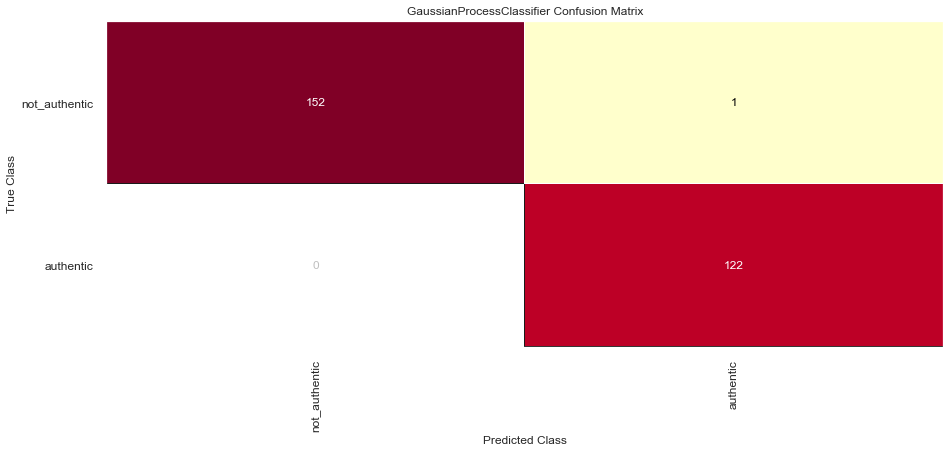

In [23]:
for model in models:
    try:
        visualise_out_of_sample(X_train, y_train, X_test, y_test, model)
    except Exception as e:
        raise e


# Hyperparameter Tuning

## XGBoost

In [24]:
# Xgboost GridSearch Pipeline
numeric_transformer = Pipeline(steps=[
        ('scale_x_num', StandardScaler())
    ])

pre_processor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, feature_names)
])

clf = Pipeline(steps=[
    ('preprocessor', pre_processor),
    ('classifier', XGBClassifier())
    ])

In [25]:
class_weight = y_train['class'].value_counts()[0] / y_train['class'].value_counts()[1]

In [26]:
search_space = {
    'classifier__n_estimators': [x for x in np.arange(100, 500).tolist()],
    'classifier__base_score': [np.round(x, 1) for x in np.arange(0.1, 0.99, 0.1).tolist()],
    'classifier__scale_pos_weight': [1, class_weight]
}

In [27]:
xg_grid_search = GridSearchCV(estimator=clf,
                              param_grid=search_space,
                              scoring='balanced_accuracy',
                              cv=10,
                              n_jobs=2,
                              verbose=5)

In [28]:
xg_grid_search.fit(X_train, y_train.values.flatten())

Fitting 10 folds for each of 7200 candidates, totalling 72000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 110 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 290 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done 542 tasks      | elapsed:   18.9s
[Parallel(n_jobs=2)]: Done 866 tasks      | elapsed:   31.4s
[Parallel(n_jobs=2)]: Done 1262 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 1730 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 2270 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 2882 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 3566 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 4322 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 5150 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 6050 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done 7022 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 8066 tasks      | elapsed:  8.9min


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scale_x_num',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                  

In [29]:
xg_grid_search.best_score_

0.9981548875808075

In [30]:
xg_grid_search.score(X=X_test, y=y_test)

0.9967320261437909

# Final Pipeline

In [31]:
# Final Pipeline
final_num_transformer = Pipeline(steps=[
        ('scale_x_num', StandardScaler())
    ])

final_processor = ColumnTransformer(transformers=[
    ('num', final_num_transformer, feature_names)
])


# Bundled models
voters = VotingClassifier(estimators=[
    ('mlp', MLPClassifier(max_iter=1000)),
    ('svc', SVC())
], voting='hard')

final_clf = Pipeline(steps=[
    ('final_preprocessor', final_processor),
    ('final_classifier', voters)
])


In [32]:
final_clf.fit(X, y.values.flatten())
final_preds = final_clf.predict(X)
print(balanced_accuracy_score(y_true=y, y_pred=final_preds))

1.0


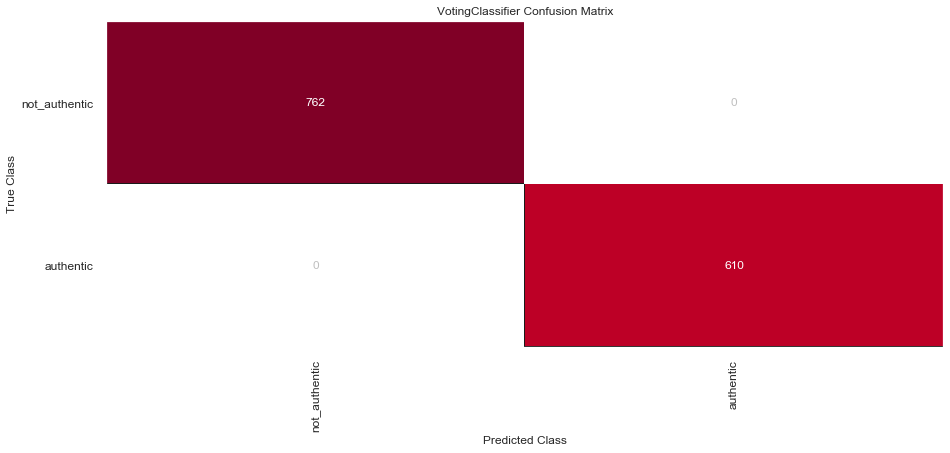

In [34]:
# Final Confusion Matrix
final_cm = ConfusionMatrix(final_clf, classes=['not_authentic', 'authentic'])
final_cm.fit(X, y.values.flatten())
final_cm.score(X, y.values.flatten())
final_cm.show();